<a href="https://colab.research.google.com/github/Gedeon-m-gedus/Image_Processing/blob/master/CV_13_completion_practice_LAB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image completion with low rank matrix and tensor factorization


### Import packages


In [ ]:
import scipy.io
import pylab as plt
import random
import numpy as np
import torch
!pip install tensorly
import tensorly as tl
tl.set_backend('pytorch')
import PIL
from PIL import Image
import torch.optim 
!wget -nc https://insidetheperimeter.ca/wp-content/uploads/2015/11/Albert_einstein_by_zuzahin-d5pcbug-WikiCommons.jpg




     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 163kB 8.4MB/s 
  Created wheel for tensorly: filename=tensorly-0.4.5-cp36-none-any.whl size=100156 sha256=4d50bbe507f59af3786ac64d3201f0150c129573f6f2de35d4aa66a7dae5c5ae
  Stored in directory: /root/.cache/pip/wheels/44/ae/02/8d00229a4fd0af192b48d24da903f9975c7ac10e706685fc39
Successfully built tensorly
--2020-07-21 14:01:23--  https://insidetheperimeter.ca/wp-content/uploads/2015/11/Albert_einstein_by_zuzahin-d5pcbug-WikiCommons.jpg
Resolving insidetheperimeter.ca (insidetheperimeter.ca)... 104.27.165.116, 172.67.197.115, 104.27.164.116, ...
Connecting to insidetheperimeter.ca (insidetheperimeter.ca)|104.27.165.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130517 (127K) [image/jpeg]
Saving to: ‘Albert_einstein_by_zuzahin-d5pcbug-WikiCommons.jpg’

Albert_einstein_by_ 100%[===================>] 127.46K  --.-KB/s    in 0.1s    

2020-07-21 14:01:23 (945 KB/s) - ‘

### Load image and generate dataset

Here the dataset is a set of observed pixels from the image (`obs_entries_indices, obs_entries_pixels`).


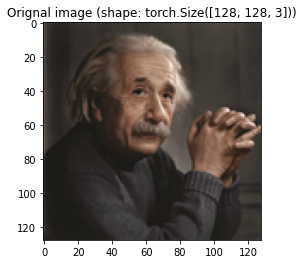

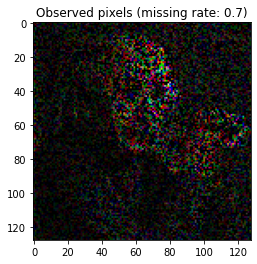

In [ ]:
def extract_observed_entries(tensor, missing_rate):
    shape = tensor.shape
    n_pixels = np.prod(shape)
    idx = random.sample(range(n_pixels),int((1-missing_rate)*n_pixels))
    obs_entries = np.unravel_index(idx,shape)
    obs_entries_indices = np.array(obs_entries)
    obs_entries_pixels = tensor[obs_entries]
    ret = [obs_entries_indices,obs_entries_pixels]

    masked_tensor = np.zeros(tensor.shape)
    masked_tensor[obs_entries] = tensor[obs_entries]
    ret.append(masked_tensor)
    return ret

missing_rate = 0.7

image = PIL.Image.open('Albert_einstein_by_zuzahin-d5pcbug-WikiCommons.jpg')
image.thumbnail((200,128),Image.ANTIALIAS)

image = tl.tensor(np.array(image), dtype=torch.float)
image = image[:,:128,:]

obs_entries_indices,obs_entries_pixels,image_missing = extract_observed_entries(image,missing_rate)
data = obs_entries_indices,obs_entries_pixels

plt.figure()
plt.imshow(image/255)
plt.title(f'Orignal image (shape: {image.shape})')
plt.figure()
plt.imshow(image_missing/255,cmap='gray')
plt.title(f'Observed pixels (missing rate: {missing_rate})')
plt.show()


Loss function:
$$\mathcal{L}(T) = \frac{1}{|\Omega|} \sum_{(i_1,i_2,i_3)\in\Omega} (T_{i_1i_2i_3}-X_{i_1i_2i_3})^2$$
where $\Omega$ is the set of indices of observed pixels and $X$ is the original image.

In [ ]:
def compute_completion_loss(tensor, data):
    idx, vals = data
    return 1/len(vals) * torch.dist(tensor[idx].reshape(1, -1),vals)



### Completion with low rank matrix factorization

Here is an example of how to use Tensorly+pytorch to solve a matrix completion problem.  We treat the input image tensor as matrix by reshaping the tensor into a two dimensional matrix. Then weuse pytorch to construct a low rank matrix factorization structure and use gradient descent to train this structure and get the completed matrix but doing simple matrix multiplication. Note here we assume the first matricization of the recovered image must be of low matrix rank.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.06081234663724899		 total loss (whole image): 0.05853455513715744


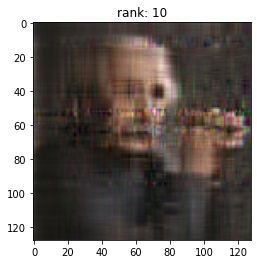

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.026050087064504623		 total loss (whole image): 0.06125195324420929


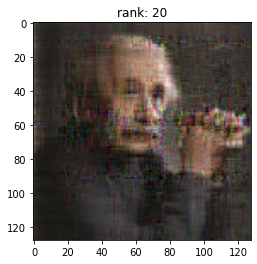

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.005726597737520933		 total loss (whole image): 0.05675720423460007


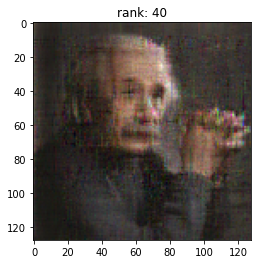

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.0012248640414327383		 total loss (whole image): 0.05343393608927727


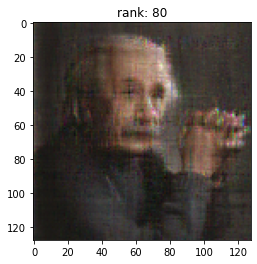

In [ ]:
for rank in [10,20,40,80]:
  max_epochs = 1000
  init_std = 0.1
  matrix_shape = [image.shape[0],image.shape[1]*image.shape[2]]
  # Initialization
  A = torch.randn(matrix_shape[0],rank)*init_std
  B = torch.randn(rank,matrix_shape[1])*init_std
  # Let pytorch know that A and B are considered as parameters and will obtain the gradients
  A.requires_grad_(True)
  B.requires_grad_(True)
  # Set optimizer
  optim = torch.optim.RMSprop([A,B],lr=0.01)
  for epoch in range(max_epochs):
      # Compute loss 
      loss = compute_completion_loss((A @ B).reshape(image.shape), data)
      # Set gradient to zero: Pytorch accumulate gradient for all the epochs, therefore need to set the gradient to zero for each epoch
      optim.zero_grad()
      # Compute the gradient
      loss.backward()
      # Do gradient descdent
      optim.step()
  # Reconstruct the image
  recovered_image = (A@B).reshape(image.shape).detach()
  total_loss = 1/recovered_image.numel() * torch.dist(recovered_image,image)
  print(f"final training loss: {loss}\t\t total loss (whole image): {total_loss}")
  plt.title(f"rank: {rank}")
  plt.imshow(recovered_image/255)
  plt.show()

### Completion with low rank tensor train factorization

Use the preivous example, implement a Pytorch-based tensor train completion method for the given image. Try to explore with the rank of the tensor train strucutre to obtain the best result. Plot the relationship between the loss and number of parameters of the constructed TT structure. In addition, plot the completed images for each rank you have tried. Note here we assume the recovered image must be of low tensor train rank.

As we have discussed in class, tensor train is espeically benificial when the tensor have many dimension. In this question, we will assume that the tensor to be recovered is of shape `[4, 4, 4, 2, 4, 4,  4,  2, 3]` (Note this is just a reshape of the original image shape), that is you need to initialize your tensor train w.r.t this new shape and then do the TT completion w.r.t this structure as well. Explore various TT rank and plot the relationship between the loss and number of parameters of the constructed TT structure. In addition, plot the completed images for each rank you have tried.
 

In [ ]:
tensor_shape = [4,4,4,2,4,4,4,2,3]
